In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [3]:
## Get Data
input_week_1_dir = "/Users/akshayprabhu/Desktop/Kaggle NFL/data/train/input_2023_w01.csv"
input_df = pd.read_csv(input_week_1_dir)

output_week_1_dir = "/Users/akshayprabhu/Desktop/Kaggle NFL/data/train/output_2023_w01.csv"
output_df = pd.read_csv(output_week_1_dir)

In [4]:
games = input_df['game_id'].nunique()
plays = input_df['play_id'].nunique()
players = input_df['nfl_id'].nunique()

In [5]:
print(f"Number of games: {games}")
print(f"Number of plays: {plays}")
print(f"Number of players: {players}")

Number of games: 16
Number of plays: 748
Number of players: 737


In [6]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285714 entries, 0 to 285713
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   285714 non-null  int64  
 1   play_id                   285714 non-null  int64  
 2   player_to_predict         285714 non-null  bool   
 3   nfl_id                    285714 non-null  int64  
 4   frame_id                  285714 non-null  int64  
 5   play_direction            285714 non-null  object 
 6   absolute_yardline_number  285714 non-null  int64  
 7   player_name               285714 non-null  object 
 8   player_height             285714 non-null  object 
 9   player_weight             285714 non-null  int64  
 10  player_birth_date         285714 non-null  object 
 11  player_position           285714 non-null  object 
 12  player_side               285714 non-null  object 
 13  player_role               285714 non-null  o

In [7]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32088 entries, 0 to 32087
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   game_id   32088 non-null  int64  
 1   play_id   32088 non-null  int64  
 2   nfl_id    32088 non-null  int64  
 3   frame_id  32088 non-null  int64  
 4   x         32088 non-null  float64
 5   y         32088 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.5 MB


# Overview

### Data
To train our model, we used data from week 1 of the 2023 NFL season. This dataset stores player tracking information from 16 games, 748 pass plays, and 737 players. The input data consists of the tracking infromation before the QB passes the ball and the output data contains tracking information after the ball is thrown. The input data has 23 columns of containing identification information (e.g. game, play, players, frame), play location information, player information,  and kinematic information (e.g. speed, acceleration, direction, etc.). The output data contains only 6 columns of information, indentification information and the x,y coordinates of the player.

### Goal
The input data has a feature named 'player_to_predict' which acts as a flag marking which players movement must be predicted. The goal of the model is to be able to predict the movement of the given players ((x,y) coordinates), after the throw has been made, given the pre throw context.

### Model Building Logic
In order to make the most accurate model, it would require more complex machine learning models that could learn spatial relations and sequential patterns in more detail. Since this is beyond the scope of what I have currently learned, I decided to attempt to use classical machine learning to develop a regression model that autoregressively predicts the next frame, builds features given the predicted coordinates, feeds the features from the predicted values back into the model, and repeats for 'num_frames_output' times.

In [8]:
def merge_df(input_df, output_df):
    '''
    Merge input dataframe and output data frame on gameand play id. Add context to output data, 
    marking them as post throw frames and adding time relative time after throw. 
    '''
    
    columns = ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_to_predict','play_direction', 
        'absolute_yardline_number','player_height', 'player_weight', 'player_position', 'player_side', 
           'player_role', 'x', 'y', 'num_frames_output', 'ball_land_x', 'ball_land_y']
    
    # Step 1: get the max input frame per play
    frame_offsets = (
        input_df.groupby(["game_id", "play_id"])["frame_id"]
        .max()
        .reset_index()
        .rename(columns={"frame_id": "maxInputFrame"})
    )

    # Step 2: merge offsets into output_df
    output_df.loc[:,'is_post_throw'] = 1
    output_shifted = output_df.merge(frame_offsets, on=["game_id", "play_id"], how="left")

    # Step 3: shift the output frameIds
    output_shifted["frame_id"] = output_shifted["frame_id"] + output_shifted["maxInputFrame"]

    # Step 4: (optional) bring over team/position info from input
    output_shifted = output_shifted.merge(
        input_df[["game_id", "play_id", "nfl_id"]].drop_duplicates(),
        on=["game_id", "play_id", "nfl_id"],
        how="left"
    )

    # Step 5: combine input + adjusted output
    df = pd.concat([input_df, output_shifted.drop(columns=["maxInputFrame"])], ignore_index=True)
    
    return df

def add_throw_context(df):
    
    df["is_post_throw"] = df["play_direction"].isna().astype(np.int8)
    # Step 6: add a new feature 'throw_frame_id' that represents frame relative to time of throw
    throw_frame = (
        df.loc[df["is_post_throw"] == 1]
          .groupby(["game_id","play_id"])["frame_id"]
          .min()
          .rename("throw_frame_id")
    )

    df = df.merge(throw_frame, on=["game_id","play_id"], how="left")

    # fallback: no post-throw → use last frame of the play
    fallback = df.groupby(["game_id","play_id"])["frame_id"].transform("max")
    df["throw_frame_id"] = df["throw_frame_id"].fillna(fallback)
    
    # Step 7: Add 't_rel_frames' 
    df["t_rel_frames"] = df["frame_id"] - df["throw_frame_id"]
    
    group_cols = ["game_id", "play_id", "nfl_id"]

    df = df.sort_values(group_cols + ["frame_id"])
    first = df.groupby(group_cols).transform("first")
    
    return df.fillna(first).infer_objects(copy=False)

In [9]:
def regularize_play(df):
    df = df.sort_values(
        by=['game_id', 'play_id', 'nfl_id'],
        ascending=[True, True, True]
    ).reset_index(drop=True)
    
    df.loc[df['play_direction'] == 'right', 'LOS'] = 10 + df['absolute_yardline_number']
    df.loc[df['play_direction'] == 'left', 'LOS'] = 110 - df['absolute_yardline_number']
    
    
    df.loc[df['play_direction'] == 'right', 'ball_land_x'] = 10 + df['ball_land_x'] - df['LOS']
    df.loc[df['play_direction'] == 'left', 'ball_land_x'] = 110 - df['ball_land_x'] - df['LOS']
    
    
    df.loc[df['play_direction'] == 'left', 'ball_land_y'] = 53.3 - df['ball_land_y']
    
    df.loc[df['play_direction'] == 'right', 'x'] = 10 + df['x'] - df['LOS']
    df.loc[df['play_direction'] == 'left', 'x'] = 110 - df['x'] - df['LOS']
    
    df.loc[df['play_direction'] == 'left', 'y'] = 53.3 - df['y']
    
    return df

In [146]:
def three_window_horizon(df, inference=False):
    df = df[df['player_to_predict'] == True]
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    ## get delta x,y values
    df[['delta_x', 'delta_y']] = (
        df.groupby(['game_id', 'play_id', 'nfl_id'])[['x', 'y']]
            .diff(-1)   # (x_t - x_{t-1}); shift if you want it aligned at t
    )
    
    df.loc[:, 'delta_x'] = df['delta_x'] * -1
    df.loc[:, 'delta_y'] = df['delta_y'] * -1
    
    ## get shifted values
    for k in [1, 2]:
        df[f"x_{k}"] = df.groupby(["game_id","play_id","nfl_id"])["x"].shift(k)
        df[f"y_{k}"] = df.groupby(["game_id","play_id","nfl_id"])["y"].shift(k)
    
    
    df["2_frame_velocity"] = np.sqrt(
        (df["x"] - df["x_2"])**2 + (df["y"] - df["y_2"])**2
    ) / 0.2
    
    df["1_frame_velocity"] = np.sqrt(
        (df["x"] - df["x_1"])**2 + (df["y"] - df["y_1"])**2
    ) / 0.1
    
    df["acceleration"] = (
        df["1_frame_velocity"]
        - df.groupby(["game_id","play_id","nfl_id"])["1_frame_velocity"].shift(1)
    ) / 0.1
    
    dx = df["x"] - df.groupby(["game_id","play_id","nfl_id"])["x"].shift(1)
    dy = df["y"] - df.groupby(["game_id","play_id","nfl_id"])["y"].shift(1)

    df["direction_rad"] = np.arctan2(dy, dx)      # angle in radians
    df["dir_sin"] = np.sin(df["direction_rad"])   # model-friendly
    df["dir_cos"] = np.cos(df["direction_rad"])
    
    if inference:
        df = df.dropna(subset=['2_frame_velocity'])
    else:
        df = df.dropna()
    
    return df

In [11]:
df = merge_df(input_df, output_df)
df = add_throw_context(df)
df = regularize_play(df)
df = three_window_horizon(df)

In [28]:
df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x_1,y_1,x_2,y_2,2_frame_velocity,1_frame_velocity,acceleration,direction_rad,dir_sin,dir_cos
0,2023091708,3082,True,44830,3,left,54.0,Adoree' Jackson,5-11,185.0,...,6.65,20.34,6.65,20.32,0.111803,0.100000,-1.000000,0.000000,0.000000,1.000000e+00
1,2023091708,3082,True,44830,4,left,54.0,Adoree' Jackson,5-11,185.0,...,6.66,20.34,6.65,20.34,0.070711,0.100000,0.000000,1.570796,1.000000,6.123234e-17
2,2023091708,3082,True,44830,5,left,54.0,Adoree' Jackson,5-11,185.0,...,6.66,20.35,6.66,20.34,0.180278,0.316228,2.162278,0.321751,0.316228,9.486833e-01
3,2023091708,3082,True,44830,6,left,54.0,Adoree' Jackson,5-11,185.0,...,6.69,20.36,6.66,20.35,0.300000,0.316228,0.000000,-0.321751,-0.316228,9.486833e-01
4,2023091708,3082,True,44830,7,left,54.0,Adoree' Jackson,5-11,185.0,...,6.72,20.35,6.69,20.36,0.250000,0.223607,-0.926210,-1.107149,-0.894427,4.472136e-01


# Feature Engineering

### Input and Output Alignment
Input and output frames were merged on game, play, and player IDs, with time-relative-to-throw features added to explicitly distinguish pre-throw and post-throw behavior, allowing the model to learn different movement dynamics across phases.

### Regularization
All plays were standardized to face right by normalizing direction and re-centering x-coordinates relative to the line of scrimmage, reducing variance caused by field orientation and play location.

### Two-Window Horizon Design

#### Target
Rather than predicting absolute positions, the model predicts Δx and Δy to reduce inter-play variance and focus learning on movement dynamics.

#### Features
Context is built using the previous two windows of x and y coordinates to derive velocity, acceleration, and direction, enabling recursive frame prediction using only prior observed or predicted positions without relying on unavailable future features.

In [13]:
# ----------------------------
# 1. Select features and target
# ----------------------------
num_features = [
    "x", "y",          # current position
    'x_1', 'y_1', 'x_2', 'y_2', # prev positions
    '2_frame_velocity', '1_frame_velocity', 'acceleration',# kinematics
    'direction_rad','dir_sin', 'dir_cos', # direction
    "LOS",             # context
    "ball_land_x", "ball_land_y", # ball landing spot
    'is_post_throw', 'throw_frame_id', 't_rel_frames' # frame info
]

cat_features = [
    "player_position",
    "player_role"
]

target = ["delta_x", "delta_y"]

df = df.dropna(subset=target)  # ensure target exists

X = df[num_features + cat_features]
y = df[target]

# group by play to avoid leakage across time
groups = df["game_id"].astype(str) + "_" + df["play_id"].astype(str)

In [14]:
# ----------------------------
# 2. Preprocessing pipeline
# ----------------------------

# scale each numerical column
# use polynomial features to mimic curve ...
numeric_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  # start linear
])

# one hot encode categorical features
categorical_pipe = OneHotEncoder(handle_unknown="ignore")

# create prepreocessing transformer
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])

In [15]:
# ----------------------------
# 3. Model (regularized AR)
# ----------------------------
model = Pipeline([
    ("prep", preprocess),
    ("reg", MultiOutputRegressor(Ridge(alpha=1.0)))
])

In [16]:
# ----------------------------
# 4. Cross-validation
# ----------------------------
cv = GroupKFold(n_splits=5)

In [17]:
scores = []
df["pred_dx"] = np.nan
df["pred_dy"] = np.nan

for train_idx, test_idx in cv.split(X, y, groups):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[test_idx])
    df.loc[X.index[test_idx], "pred_dx"] = y_pred[:, 0]
    df.loc[X.index[test_idx], "pred_dy"] = y_pred[:, 1]
    score = model.score(X.iloc[test_idx], y.iloc[test_idx])
    scores.append(score)

mse_x = mean_squared_error(df["delta_x"], df["pred_dx"])
mse_y = mean_squared_error(df["delta_y"], df["pred_dy"])
rmse_x, rmse_y = mse_x**0.5, mse_y**0.5

print("CV R² (mean):", sum(scores) / len(scores))
print("RMSE delta x:", rmse_x)
print("RMSE delta y:", rmse_y)


CV R² (mean): 0.9923571559076324
RMSE delta x: 0.02459154788453617
RMSE delta y: 0.0231665672128019


In [18]:
def random_play(rs=42, df=df):
    # pick a random play
    play = (
        df[["game_id", "play_id"]]
        .drop_duplicates()
        .sample(1, random_state=rs)
        .iloc[0]
    )

    play_df = (
        df[(df["game_id"] == play.game_id) & (df["play_id"] == play.play_id)]
        .sort_values(['nfl_id', 'frame_id'])
    )
    
    return play_df

def display_res(play_df):
    # Δx plot
    plt.figure()
    plt.plot(play_df["frame_id"], play_df["delta_x"], label="Δx true")
    plt.plot(play_df["frame_id"], play_df["pred_dx"], label="Δx pred")
    plt.xlabel("Frame")
    plt.ylabel("Δx")
    plt.legend()
    plt.show()

    # Δy plot
    plt.figure()
    plt.plot(play_df["frame_id"], play_df["delta_y"], label="Δy true")
    plt.plot(play_df["frame_id"], play_df["pred_dy"], label="Δy pred")
    plt.xlabel("Frame")
    plt.ylabel("Δy")
    plt.legend()
    plt.show()

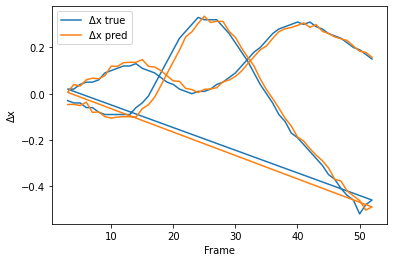

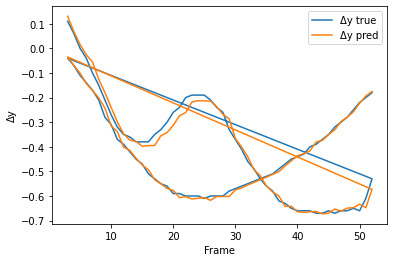

In [19]:
display_res(random_play(df=df))

In [349]:
filename = 'model1.sav'
pickle.dump(model, open(filename, 'wb'))